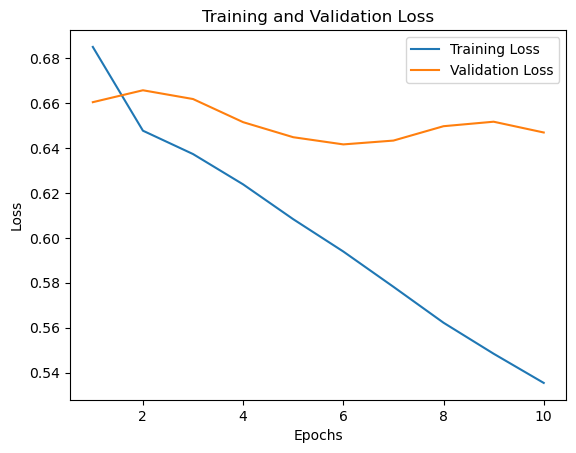

In [1]:
import matplotlib.pyplot as plt 
plt.plot([1,2,3,4,5,6,7,8,9,10], [0.685, 0.6477, 0.6373, 0.6238, 0.6083, 0.5939, 0.5782, 0.5622, 0.5484, 0.5354], label="Training Loss")
plt.plot([1,2,3,4,5,6,7,8,9,10], [0.6604, 0.6657, 0.6618, 0.6515, 0.6448, 0.6416, 0.6433, 0.6497, 0.6517, 0.6469], label="Validation Loss")
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="best")
plt.show()

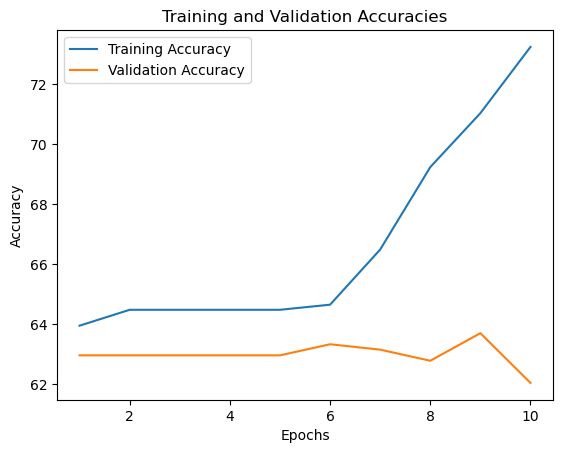

In [2]:
import matplotlib.pyplot as plt
train_acc =  [0.6395, 0.6448, 0.6448, 0.6448, 0.6448, 0.6465, 0.6649, 0.6924, 0.7104, 0.7325]
test_acc = [0.6296, 0.6296, 0.6296, 0.6296, 0.6296, 0.6333, 0.6315, 0.6278, 0.6370, 0.6204]
tr_ac = [i*100 for i in train_acc]
te_acc = [i*100 for i in test_acc]
plt.plot([1,2,3,4,5,6,7,8,9,10], tr_ac, label="Training Accuracy")
plt.plot([1,2,3,4,5,6,7,8,9,10], te_acc, label="Validation Accuracy")
plt.title('Training and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="best")
plt.show()

In [ ]:
import os
os.getcwd()

In [ ]:
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import torch
from clip import load, tokenize
import torch.nn as nn
from tqdm import tqdm   
import pandas as pd
from PIL import Image
from sklearn.manifold import TSNE
model, preprocess = load("ViT-B/32", device="cuda" if torch.cuda.is_available() else "cpu")
device = "cuda"

class TextImageDataset(torch.utils.data.Dataset):
    def __init__(self, texts, images, labels):
        self.texts = texts # a list of text strings
        self.images = images # a list of image paths
        self.labels = labels # a list of binary labels (0 or 1)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, index):
        # Load and transform the image
        image = Image.open(self.images[index])
        # image = transform(image)
        image = preprocess(image)

        # Tokenize the text
        text = tokenize(self.texts[index], truncate=True)

        # Get the label
        label = torch.tensor(self.labels[index], dtype=torch.long)

        return image, text, label  

class TextImageClassifier(nn.Module):
    def __init__(self):
        super(TextImageClassifier, self).__init__()
        # Get the embedding size from the CLIP model
        self.embedding_size = model.visual.output_dim

        # Define the feed forward network with 3 layers
        self.fc1 = nn.Linear(self.embedding_size * 2, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 2) # binary classification

    def forward(self, image, text):
        # Get the image and text embeddings from the CLIP model
        with torch.no_grad():
            image_features = model.encode_image(image)
            text_features = model.encode_text(text)

        # Concatenate the embeddings
        features = torch.cat([image_features, text_features], dim=1).to(torch.float32)

        # Pass through the feed forward network
        output = self.fc1(features)
        output = torch.relu(output)
        output = self.fc2(output)
        output = torch.relu(output)
        output = self.fc3(output)

        return output
    
def JsonlToDf(file):
    # with open(file) as f:
    #     data = json.load(f)
    # df = pd.DataFrame(data)
    df = pd.read_json(file, lines=True)

    return df

file_hate_images = "./Data/hate_df.csv"
file_non_hate_images = "./Data/nonhate_df.csv"
file_texts = "/home2/bagler/DL_A4/Data/tsne_txt (1).csv"

df_hate_images = pd.read_csv(file_hate_images)
df_nonhate_images = pd.read_csv(file_non_hate_images)
df_texts = pd.read_csv(file_texts)

df_hate = pd.concat([df_hate_images.iloc[:, :-1], df_texts.loc[df_texts["target"] == 1]["text"]], axis=1)
df_nonhate = pd.concat([df_nonhate_images.iloc[:, :-1], df_texts.loc[df_texts["target"] == 0]["text"]], axis=1)

test_hate_texts = df_hate["text"].tolist()
test_nonhate_texts = df_nonhate["text"].tolist()    
label_hate = df_hate["label"].tolist()
label_nonhate = df_nonhate["label"].tolist() 
images_hate = ["./Data/" + str(img) for img in df_hate["img"].tolist()]  
images_nonhate = ["./Data/" + str(img) for img in df_nonhate["img"].tolist()]    

classifier = TextImageClassifier()
classifier.load_state_dict(torch.load("./models/best_model.pt"))
classifier.eval() 
classifier.to(device)
features = TextImageClassifier(*list(classifier.children())[:-1])
dataset_hate = TextImageDataset(test_hate_texts, images_hate, label_hate) 
dataset_nonhate = TextImageDataset(test_nonhate_texts, images_nonhate, label_nonhate) 
loader_hate = torch.utils.data.DataLoader(dataset_hate, batch_size=len(dataset_hate.texts), shuffle=False)  
loader_nonhate = torch.utils.data.DataLoader(dataset_nonhate, batch_size=len(dataset_nonhate.texts), shuffle=False)  

for images, texts, labels in loader_hate:
    texts = texts.reshape(50,-1)
    images = images.to(device)
    texts = texts.to(device)
    labels =  labels.to(device)
    print(features(images,texts).cpu().detach().numpy().shape)
    hate_features = features(images, texts).cpu().detach().numpy().reshape(50, -1)
    hate_labels = labels.cpu().numpy().flatten()

for images, texts, labels in loader_nonhate:
    images = images.to(device)
    texts = texts.to(device)
    labels =  labels.to(device)
    print(features(images,texts).cpu().detach().numpy().shape)
    nonhate_features = features(images, texts).cpu().detach().numpy().reshape(50, -1)
    nonhate_labels = labels.cpu().numpy().flatten()

print(hate_features.shape)
print(hate_labels.shape)
print(nonhate_features.shape)
print(nonhate_labels.shape)




# TSNE plot of nonhate features
plt.figure(figsize=(8, 5))
hate_embeddings = TSNE(n_components=2).fit_transform(hate_features)
nonhate_embeddings = TSNE(n_components=2).fit_transform(nonhate_features)
plt.scatter(hate_embeddings[:, 0], hate_embeddings[:, 1], c=hate_labels, marker='o', cmap='Spectral', label='hate')
plt.scatter(nonhate_embeddings[:, 0], nonhate_embeddings[:, 1], c=nonhate_labels, marker='v', cmap='Set1', label='non hate')
plt.xlabel("component 1")
plt.ylabel("component 2")
plt.title("2D TSNE plot of Hate and Non Hate features")
plt.legend()
plt.show()